In [31]:
from utils import datasets
from utils.parser import * 
import os 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf 
from models import * 
from utilities import *
from train_model_utilities import * 
import networkx as nx 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
dataset_name = 'seq_FUN'
train, valid, test = initialize_dataset(dataset_name, datasets)

scalar = StandardScaler().fit(train.X)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean').fit(train.X)
train.X = scalar.transform(imputer.transform(train.X))
valid.X = scalar.transform(imputer.transform(valid.X))
test.X = scalar.transform(imputer.transform(test.X))

train.Y = tf.convert_to_tensor(train.Y, tf.float32)
valid.Y = tf.convert_to_tensor(valid.Y, tf.float32)
test.Y = tf.convert_to_tensor(test.Y, tf.float32)

In [3]:
train_data = tf.data.Dataset.from_tensor_slices(
    (train.X, train.Y)
).shuffle(buffer_size = train.X.shape[0]).batch(batch_size=4)

In [32]:
def get_structure_from_adajancency(adajancency):
    structure = np.zeros(adajancency.shape)
    g = nx.DiGraph(adajancency) # train.A is the matrix where the direct connections are stored 
    for i in range(len(adajancency)):
        ancestors = list(nx.descendants(g, i)) #here we need to use the function nx.descendants() because in the directed graph the edges have source from the descendant and point towards the ancestor 
        if ancestors:
            structure[i, ancestors] = 1
    return structure 

AU(PRC) 
train: 0.9940987088099398, validation 0.3334440185174692, test 0.337960935833137


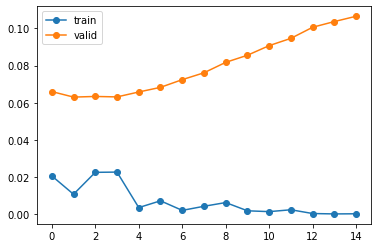

In [5]:
structure = get_structure_from_adajancency(train.A)
model = HMCModel(structure, 500, [2000,2000], 0.7)
loss_fn = get_loss_fn_coherent(structure)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5)
train_loss_list, valid_loss_list, train_score_list, valid_score_list, test_score_list = train_epoch(model, 
            optimizer, loss_fn, 'coherent_hmc', 15, 
            train_data, train.X, train.Y, valid.X, valid.Y, test.X, test.Y)

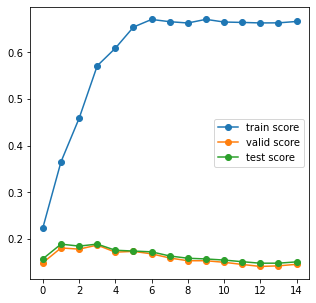

In [6]:
plt.figure(figsize=(5,5))
plt.plot(train_score_list, '-o', label='train score')
plt.plot(valid_score_list, '-o', label = 'valid score')
plt.plot(test_score_list, '-o', label = 'test score')
plt.legend()

In [10]:
logits = model(test.X)
logits = model.postprocess(logits)
prob = model.get_prob(logits)
custom_score(test.Y, model.predict(test.X))

0.15106186262702276

# Traditional binary prediction model and loss function test

In [36]:
dataset_name = 'seq_FUN'
train, valid, test = initialize_dataset(dataset_name, datasets)
structure = get_structure_from_adajancency(train.A)

scalar = StandardScaler().fit(train.X)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean').fit(train.X)
train.X = scalar.transform(imputer.transform(train.X))
valid.X = scalar.transform(imputer.transform(valid.X))
test.X = scalar.transform(imputer.transform(test.X))

train.Y = tf.convert_to_tensor(train.Y, tf.float32)
valid.Y = tf.convert_to_tensor(valid.Y, tf.float32)
test.Y = tf.convert_to_tensor(test.Y, tf.float32)

train_data = tf.data.Dataset.from_tensor_slices(
    (train.X, train.Y)
).shuffle(buffer_size = train.X.shape[0]).batch(batch_size=4)

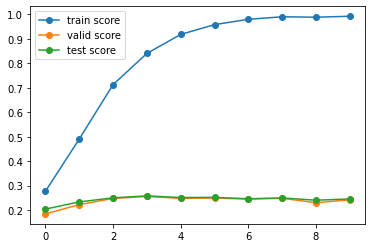

In [81]:
model = HMCModel(structure, 500, [2000,2000], 0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5)

def loss_fn(y_true, y_logits):
    idx = tf.cast(tf.reduce_sum(y_true, axis=0) != y_true.shape[0], tf.float32) # remove root nodes
    loss = softplus(y_logits) + (1-y_true) * y_logits
    loss = tf.reduce_mean(loss * idx)
    return loss 

def train_a_step(model, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        logits = model(x_batch)
        logits = model.postprocess(logits)
        loss = loss_fn(y_batch, logits)
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    return loss 

def train_epochs(model, optimizer, train_data, epochs):
    steps = train.X.shape[0] // 4
    loss_list = []
    train_score_list = []
    valid_score_list = []
    test_score_list = []
    for epoch in range(epochs):
        loss = 0
        for x_batch, y_batch in train_data.take(steps):
            loss += train_a_step(model, optimizer, x_batch, y_batch)
        loss /= steps
        loss_list.append(loss) 
        train_score = custom_score(train.Y, model.predict(train.X))
        valid_score = custom_score(valid.Y, model.predict(valid.X))
        test_score = custom_score(test.Y, model.predict(test.X))
        train_score_list.append(train_score)
        valid_score_list.append(valid_score)
        test_score_list.append(test_score)
    return loss_list, train_score_list, valid_score_list, test_score_list

loss_list, train_score_list, valid_score_list, test_score_list = train_epochs(model, 
                                                                              optimizer, 
                                                                              train_data, 
                                                                              10)
plt.plot(train_score_list, '-o', label='train score')
plt.plot(valid_score_list, '-o', label = 'valid score')
plt.plot(test_score_list, '-o', label = 'test score')
plt.legend()

In [82]:
test_score_list

[0.20376135598364287,
 0.2331973269569434,
 0.24991744777803332,
 0.2578652612843171,
 0.25109875761861733,
 0.2517972209770777,
 0.24604007610532352,
 0.24949874519433574,
 0.24008494457527307,
 0.24540777706775901]